<>:48: SyntaxWarning: invalid escape sequence '\['
<>:48: SyntaxWarning: invalid escape sequence '\['
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_5256/1176529627.py:48: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')


Dataset loaded.
Index(['Unnamed: 0', 'userName', 'Title', 'Base_Reviews', 'Rating',
       'cleaned_Review', 'Have_Issue', 'Assessability Issue Type'],
      dtype='object')
NLTK data downloaded.


[nltk_data] Error loading punkt: <urlopen error [Errno 61] Connection
[nltk_data]     refused>
[nltk_data] Error loading wordnet: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 61] Connection refused>
[nltk_data] Error loading stopwords: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_5256/1176529627.py:41: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - accuracy: 0.6259 - loss: 0.6471 - val_accuracy: 0.7336 - val_loss: 0.5477
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.7742 - loss: 0.5047 - val_accuracy: 0.7830 - val_loss: 0.4891
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 244ms/step - accuracy: 0.8005 - loss: 0.4572 - val_accuracy: 0.7524 - val_loss: 0.5170
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - accuracy: 0.6917 - loss: 295.4835 - val_accuracy: 0.7264 - val_loss: 0.5496
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 237ms/step - accuracy: 0.7547 - loss: 11588182.0000 - val_accuracy: 0.7117 - val_loss: 0.5644
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - accuracy: 0.5827 - loss: 478.0179 - val_accuracy: 0.6882 - val_loss: 0.5901
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 237ms/step - accuracy: 0.6685 - loss: 0.6069 - val_accuracy: 0.7224 - val_loss: 0.5514
Epoch 

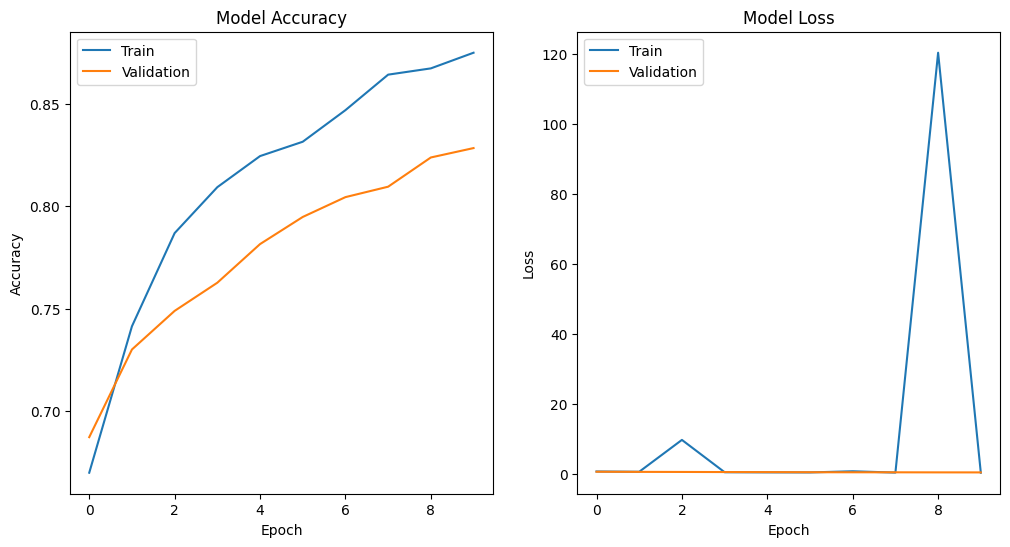

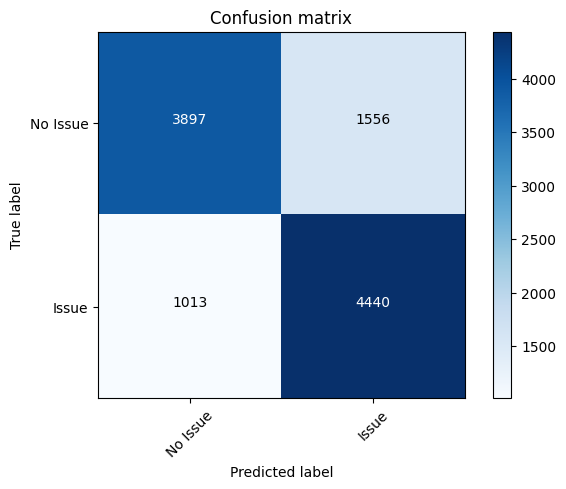

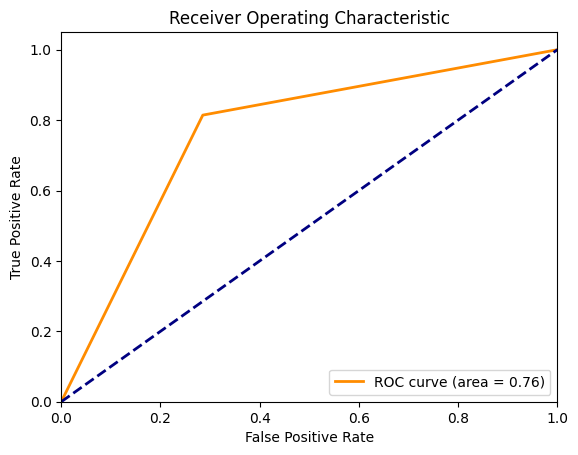

              precision    recall  f1-score   support

           0       0.79      0.71      0.75      5453
           1       0.74      0.81      0.78      5453

    accuracy                           0.76     10906
   macro avg       0.77      0.76      0.76     10906
weighted avg       0.77      0.76      0.76     10906



In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Accessibility issues new.csv', encoding='latin-1')
print("Dataset loaded.")
print(dataset.columns)
# Remove rows where the target variable has missing values
dataset = dataset.dropna(subset=['Have_Issue'])

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['Base_Reviews'] = dataset['Base_Reviews'].apply(clean_text)
dataset['Base_Reviews'].dropna(inplace=True)
dataset['Base_Reviews'] = [entry.lower() for entry in dataset['Base_Reviews']]
dataset['Base_Reviews'] = [word_tokenize(entry) for entry in dataset['Base_Reviews']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['Base_Reviews']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_Issue'] = dataset['Have_Issue'].map({'Yes': 1, 'No': 0})

# Apply oversampling to balance the classes
X = dataset['text_final']
y = dataset['Have_Issue']
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the GRU model
def build_GRU_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

# Instantiate the model
gru_model = build_GRU_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = gru_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = gru_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["No Issue", "Issue"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


<>:48: SyntaxWarning: invalid escape sequence '\['
<>:48: SyntaxWarning: invalid escape sequence '\['
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_5256/901476861.py:48: SyntaxWarning: invalid escape sequence '\['
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')


Dataset loaded.
Index(['Unnamed: 0', 'userName', 'Title', 'Base_Reviews', 'Rating',
       'cleaned_Review', 'Have_Issue', 'Assessability Issue Type'],
      dtype='object')
NLTK data downloaded.


[nltk_data] Error loading punkt: <urlopen error [Errno 61] Connection
[nltk_data]     refused>
[nltk_data] Error loading wordnet: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 61] Connection refused>
[nltk_data] Error loading stopwords: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 61]
[nltk_data]     Connection refused>
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_5256/901476861.py:41: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
/Users/nekdilkhan/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 328ms/step - accuracy: 0.6325 - loss: 29.1286 - val_accuracy: 0.5254 - val_loss: 0.6815
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 331ms/step - accuracy: 0.7481 - loss: 0.5266 - val_accuracy: 0.6585 - val_loss: 0.6013
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 288ms/step - accuracy: 0.7857 - loss: 0.4546 - val_accuracy: 0.6677 - val_loss: 0.6086
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.7096 - loss: 0.5707 - val_accuracy: 0.5706 - val_loss: 0.6779
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - accuracy: 0.7687 - loss: 0.4905 - val_accuracy: 0.5999 - val_loss: 0.6731
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step - accuracy: 0.7850 - loss: 0.4461 - val_accuracy: 0.6646 - val_loss: 0.6018
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 285ms/step - accuracy: 0.8083 - loss: 0.4450 - val_accuracy: 0.5962 - val_loss: 0.6897
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Epoch 1/10
66/66

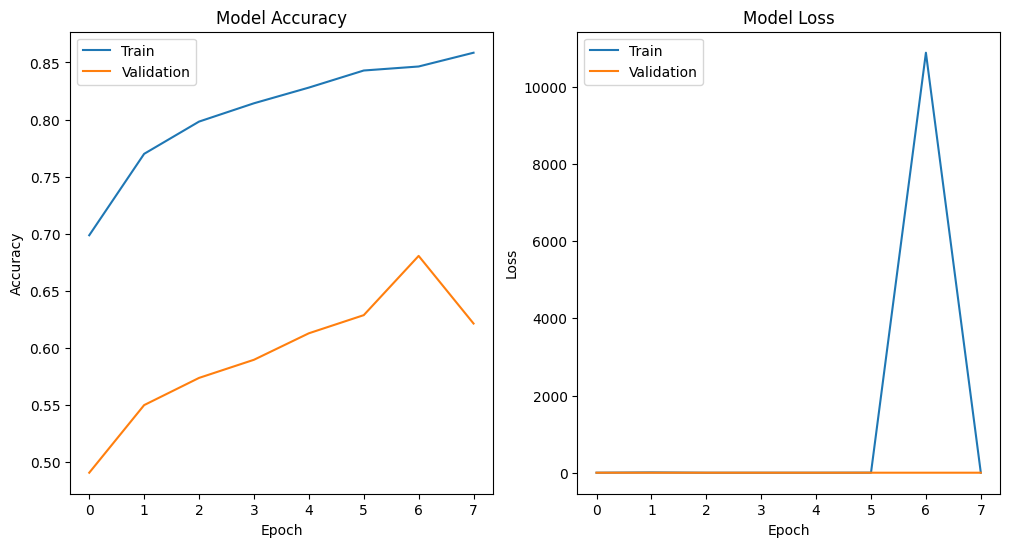

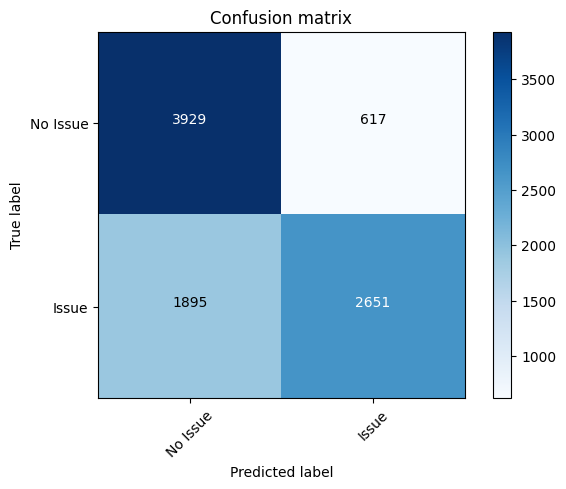

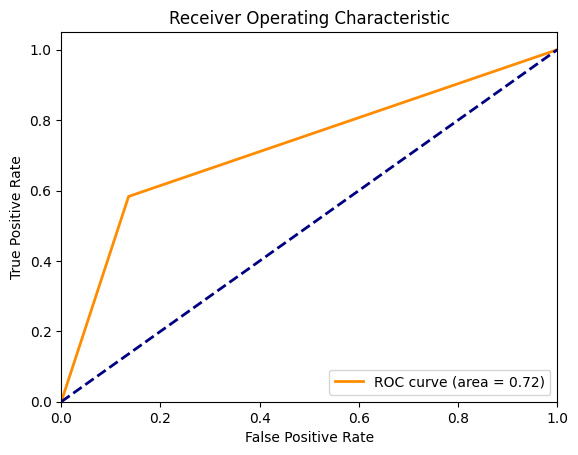

              precision    recall  f1-score   support

           0       0.67      0.86      0.76      4546
           1       0.81      0.58      0.68      4546

    accuracy                           0.72      9092
   macro avg       0.74      0.72      0.72      9092
weighted avg       0.74      0.72      0.72      9092



In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Accessibility issues new.csv', encoding='latin-1')
print("Dataset loaded.")
print(dataset.columns)
# Remove rows where the target variable has missing values
dataset = dataset.dropna(subset=['Have_Issue'])

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['Base_Reviews'] = dataset['Base_Reviews'].apply(clean_text)
dataset['Base_Reviews'].dropna(inplace=True)
dataset['Base_Reviews'] = [entry.lower() for entry in dataset['Base_Reviews']]
dataset['Base_Reviews'] = [word_tokenize(entry) for entry in dataset['Base_Reviews']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['Base_Reviews']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_Issue'] = dataset['Have_Issue'].map({'Yes': 1, 'No': 0})

# Apply undersampling to balance the classes
X = dataset['text_final']
y = dataset['Have_Issue']
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the GRU model
def build_GRU_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

# Instantiate the model
gru_model = build_GRU_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = gru_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = gru_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["No Issue", "Issue"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))
